<a href="https://colab.research.google.com/github/babar21/Deep_Learning_MVA/blob/master/MVA_MP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## $\textbf{1 Utils}$

In [0]:
import dill

# import session
#dill.load_session('notebook_env.db')

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## $\textbf{2 Getting started}$

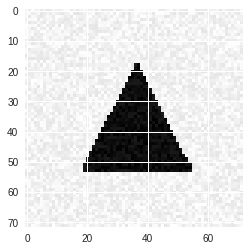

In [0]:
import matplotlib.pyplot as plt
from itertools import chain
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(30, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
#    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    # visualize 40 predictions
    fig, ax = plt.subplots(10, 4, figsize=(18,16), sharex='col', sharey='row')
    l=0
    for i in range(10):
      for j in range(4):
        I = x[l].reshape((IMAGE_SIZE,IMAGE_SIZE))
        ax[i,j].imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
        ax[i,j].set_xlim([0,1])
        ax[i,j].set_ylim([0,1])

        xy = y[l].reshape(3,2)
        tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
        ax[i,j].add_patch(tri)
        ax[i,j].set(adjustable='box-forced', aspect='equal')
        l +=1
    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]


## $\textbf{3 Simple classification}$

In [0]:
# plot function

def plot(hist, acc=False):
  if acc==True:
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
    
    ax1.plot(hist.history['loss'], marker='', label="Train")
    ax1.plot(hist.history['val_loss'], marker='', label="Test")
    ax1.set_xlabel(r'Epoch')
    ax1.set_ylabel(r'Loss')
    ax1.set_title(r'Model Loss')
    ax1.legend()
    
    ax2.plot(hist.history['acc'], marker='', label="Train")
    ax2.plot(hist.history['val_acc'], marker='', label="Test")
    ax2.set_xlabel(r'Epoch')
    ax2.set_ylabel(r'Accuracy')
    ax2.set_title(r'Model accuracy')
    ax2.legend()
    fig.tight_layout()
    plt.show()
    
  else:
    fig, ax1 = plt.subplots()
    ax1.plot(hist.history['loss'], marker='', label="Train")
    ax1.plot(hist.history['val_loss'], marker='', label="Test")
    ax1.set_xlabel(r'Epoch')
    ax1.set_ylabel(r'Loss')
    ax1.set_title(r'Model Loss')
    plt.legend()
    fig.tight_layout()
    plt.show()
      
  
  return
  

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.engine.input_layer import Input
from keras.utils import np_utils

def create_linear_network(nb_neurons, optimizer):
    ## linear classifier
    model = Sequential()
    # linear hidden layer
    model.add(Flatten(input_shape=(IMAGE_SIZE, IMAGE_SIZE)))
    model.add(Dense(nb_neurons)) 
    model.add(Activation('relu')) 
    # softmax output layer
    model.add(Dense(units=3, activation="softmax"))

    # model description
    model.summary()

    # loss function and optimizer 
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

I built the simpliest linear model we could have, with a single hidden layer with nb_neurons units. Since it is a classification problem, the output layer has 3 units, with a "softmax" activation function, to compute the probability to belong to each class. 

In [0]:
# generate training set
[X_train, Y_train] = generate_dataset_classification(300, 20)

X_train = X_train.reshape(X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 5184)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               663680    
_________________________________________________________________
activation_6 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 387       
Total params: 664,067
Trainable params: 664,067
Non-trainable params: 0
_________________________________________________________________
Train on 285 samples, validate on 15 samples
Epoch 1/20
285/285 [==============================] - 1s 3ms/step - loss: 2.2577 - acc: 0.3930 - val_loss: 1.0604 - val_acc: 0.3333
Epoch 2/20
285/285 [==============================] - 0s 180us/step - loss: 0.9085 - acc: 0

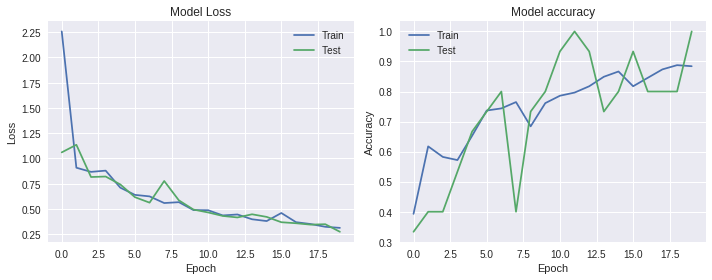

In [0]:
# parameters
nb_neurons = 128

# train model with SGD optmizer
model1 = create_linear_network(nb_neurons, 'sgd')
hist1 = model1.fit(X_train, Y_train, epochs=20, batch_size=32, validation_split=0.05)
plot(hist1, True)

The first neural network is trained using 'SGD' optimizer and achieves an accuracy of arround 0.85 on both training and test set. Since the loss is the same for the training and test set, the neural network does not seem to overfit. However, we would like to test the model with the "adam" optimizer, wich is known to be more performant.

In [0]:
X_test = generate_a_disk()/255.
X_test = X_test.reshape(1, IMAGE_SIZE, IMAGE_SIZE)

model1.predict(X_test)

array([[0.39324299, 0.6043773 , 0.00237968]], dtype=float32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 5184)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               663680    
_________________________________________________________________
activation_7 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 387       
Total params: 664,067
Trainable params: 664,067
Non-trainable params: 0
_________________________________________________________________
Train on 285 samples, validate on 15 samples
Epoch 1/20
285/285 [==============================] - 1s 4ms/step - loss: 3.0764 - acc: 0.3579 - val_loss: 1.3089 - val_acc: 0.4000
Epoch 2/20
285/285 [==============================] - 0s 201us/step - loss: 1.0595 - acc: 0

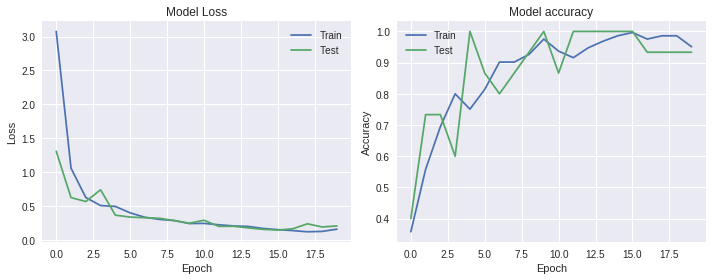

In [0]:
# train model with adam optimzer
model1bis = create_linear_network(nb_neurons, 'adam')
hist1bis = model1bis.fit(X_train, Y_train, epochs=20, batch_size=32, validation_split=0.05)
plot(hist1bis, True)

The same model trained with the "Adam" optimizer is more powerfull than with the "SGD", without overfitting the data, since both training and test set achieve a similar loss and accurary. It can be seen when we ask both model to predict the class of a circle (see cells below)

In [0]:
model1.predict(X_test)

array([[0.39324299, 0.6043773 , 0.00237968]], dtype=float32)

In [0]:
model1bis.predict(X_test)

array([[6.441046e-02, 9.353781e-01, 2.115622e-04]], dtype=float32)

On a single test, one can see that the model trained with the "adam" optimizer predicts with a higher probability the shape to be a circle compared to the model trained with the "sgd" optimizer.

## $\textbf{4 Visualization of the solution}$

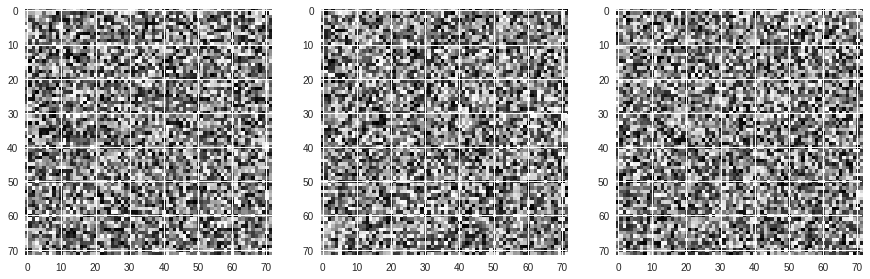

In [0]:
fig, axs = plt.subplots(1,3, figsize=(15,8))
i = 0
for ax in axs.reshape(-1):
    im = model1bis.get_weights()[0][:,i].reshape(IMAGE_SIZE, IMAGE_SIZE)
    ax.imshow(im, cmap='gray')
    i+=1


The neural network generates a intermediates representation of the data which is quite understable, even if the second plot seems to show some symetrical structure.

## $\textbf{5 A More Difficult Classification Problem}$

In [0]:
# generate training set
[X_train, Y_train] = generate_dataset_classification(1000, 20, True)

# Generate test set
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_30 (Flatten)         (None, 5184)              0         
_________________________________________________________________
dense_81 (Dense)             (None, 128)               663680    
_________________________________________________________________
activation_17 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 3)                 387       
Total params: 664,067
Trainable params: 664,067
Non-trainable params: 0
_________________________________________________________________
Train on 900 samples, validate on 100 samples
Epoch 1/20
900/900 [==============================] - 3s 3ms/step - loss: 5.7816 - acc: 0.3889 - val_loss: 6.7025 - val_acc: 0.4600
Epoch 2/20
900/900 [==============================] - 0s 217us/step - loss: 5.5201 - acc: 

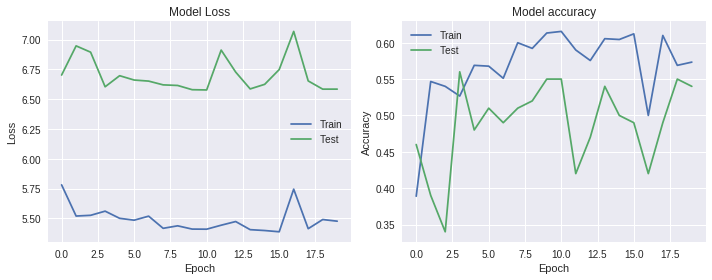

In [0]:
X_train1 = X_train.reshape(X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE)
# train model
model2 = create_linear_network(nb_neurons, 'adam')
hist2=model2.fit(X_train1, Y_train, epochs=20, batch_size=32, validation_split=0.1)
plot(hist2, True)

In [0]:
# Reshaping X_test
X_test1 = X_test.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE,)
# Evaluate model
test_loss, test_acc = model2.evaluate(X_test1, Y_test)
print('Model accuracy is {}'.format(test_acc))
print('Loss on test set is {}'.format(test_loss))

300/300 [==============================] - 0s 131us/step
Model accuracy is 0.6033333325386048
Loss on test set is 5.660330971082051


The performance of the network is rather week, with a great difference between the training and test set loss. When evaluating the model on the big test set (and not the validation test), accuracy is small but in line with what we saw on the train set, underlining that there are overfit. To get a better classification model, we should switch to a convolutionnal neural network.

In [0]:
# Define convolutionnal network
from keras.layers import Conv2D, MaxPooling2D, Dropout

from keras.layers import Dropout

def conv_network(nb_conv, size_conv, nb_neur_dense):
    model = Sequential()
    
    # convolutionnal layer
    model.add(Conv2D(nb_conv, (size_conv, size_conv), activation='relu',input_shape=(IMAGE_SIZE, IMAGE_SIZE,1)))
    
    # pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Dropout layer
    model.add(Dropout(0.25))
    
    # Flatten layer
    model.add(Flatten())
    
    # Fully connected layer
    model.add(Dense(nb_neur_dense, activation='relu'))
    
    # Dropout layer
    model.add(Dropout(0.5))
    
    # Categorical layer
    model.add(Dense(3, activation='softmax'))
    
    # model description
    model.summary()

    # loss function and optimizer 
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 68, 68, 32)        832       
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 34, 34, 32)        0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 34, 34, 32)        0         
_________________________________________________________________
flatten_34 (Flatten)         (None, 36992)             0         
_________________________________________________________________
dense_89 (Dense)             (None, 128)               4735104   
_________________________________________________________________
dropout_53 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_90 (Dense)             (None, 3)                 387       
Total para

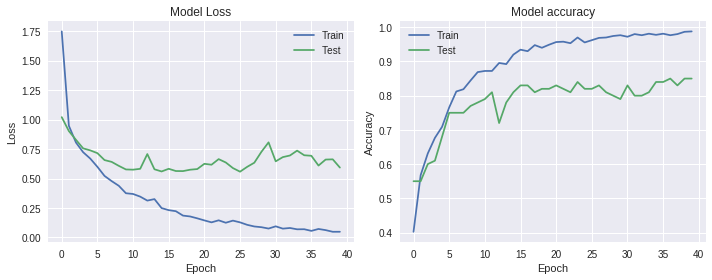

In [0]:
model3 = conv_network(32, 5, 128)

# reshaping training data for convolutionnal network
X_train2 = X_train.reshape(X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE,1)

hist3 = model3.fit(X_train2, Y_train, epochs=40, batch_size=32, validation_split=0.1)
plot(hist3, True)

In [0]:
# Reshaping test set
X_test = X_test.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE,1)
# Evaluate model
test_loss, test_acc = model3.evaluate(X_test, Y_test)
print('Model accuracy is {}'.format(test_acc))
print('Loss on test set is {}'.format(test_loss))

300/300 [==============================] - 0s 226us/step
Model accuracy is 0.88
Loss on test set is 0.5178237660725912


The CNN shows a far better classification power, improving both loss and accuracy versus the simplier NN. I tested several hyperparameters (16 or 32 for the Conv2d layer, and an increasing number of neurons in the dense layer) and it seems that increasing the size leads to better performance without overfitting the training set so much.

array([[1.3044749e-04, 9.9986959e-01, 2.0287841e-08]], dtype=float32)

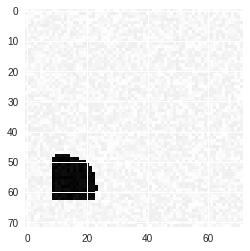

In [0]:
# testting model prediction
X_test = generate_a_disk(noise=20, free_location=True)/255.
plt.imshow(X_test.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

X_test = X_test.reshape(1, IMAGE_SIZE, IMAGE_SIZE,1)
model3.predict(X_test)

## $\textbf{6 A Regression Problem}$

In [0]:
def normalize_vertices(vert):
    # sort the vertices on the cartesian ordering
    norm_vert = []
    for list_vert in vert :
        l = len(list_vert)
        new_classif = []
        for i in range(int(l/2)):
            new_classif.append([list_vert[2*i], list_vert[2*i+1]])
        norm_vert.append(list(chain.from_iterable(sorted(new_classif))))
    return np.array(norm_vert)
    

The first idea to in a sense "normalize" the Y's is to sort them in a specific order. I first tried to sort them according to the cartesian ordering with the  normalize_vertices function.

In [0]:
from keras.optimizers import Adam

def reg_conv_network(nb_conv, size_conv, nb_neur_dense):
    model = Sequential()
    
    # convolutionnal layer & pooling layer 
    model.add(Conv2D(nb_conv, (size_conv, size_conv), activation='relu',input_shape=(IMAGE_SIZE, IMAGE_SIZE,1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    
    model.add(Conv2D(int(nb_conv/2), (size_conv, size_conv), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    
    model.add(Conv2D(int(nb_conv/2), (size_conv, size_conv), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(int(nb_conv/4), (size_conv, size_conv), activation='relu'))

    # Flatten layer
    model.add(Flatten())
    
    # Fully connected layer & Dropout layer
    model.add(Dense(nb_neur_dense, activation='relu'))
    model.add(Dropout(0.25))

    # Regression layer
    model.add(Dense(6, activation='relu'))
    
    # model description
    model.summary()

    # loss function and optimizer 
    optim = Adam(0.0005)
    model.compile(optimizer=optim,
                  loss='mse')
    return model
  

I decided to use the same king of architecture as in question 5, that is a convolutionnal neural network. The only thing we need to change is the output layer and the loss, since we now have a regression problem. So I used a dense layer with 6 neurons (since we need to predict 6 figures) and the mean squared loss. 
I first tried a very simple model with only one convolutionnal layer and a single dense layer and it was far from performing well. I had some convolutionnal/maxpool layers with decreasing size. In order to avoid overfitting, some dropout layers were also added. 

In [0]:
# Generate training set
[X_train3, Y_train3] = generate_dataset_regression(3000, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2

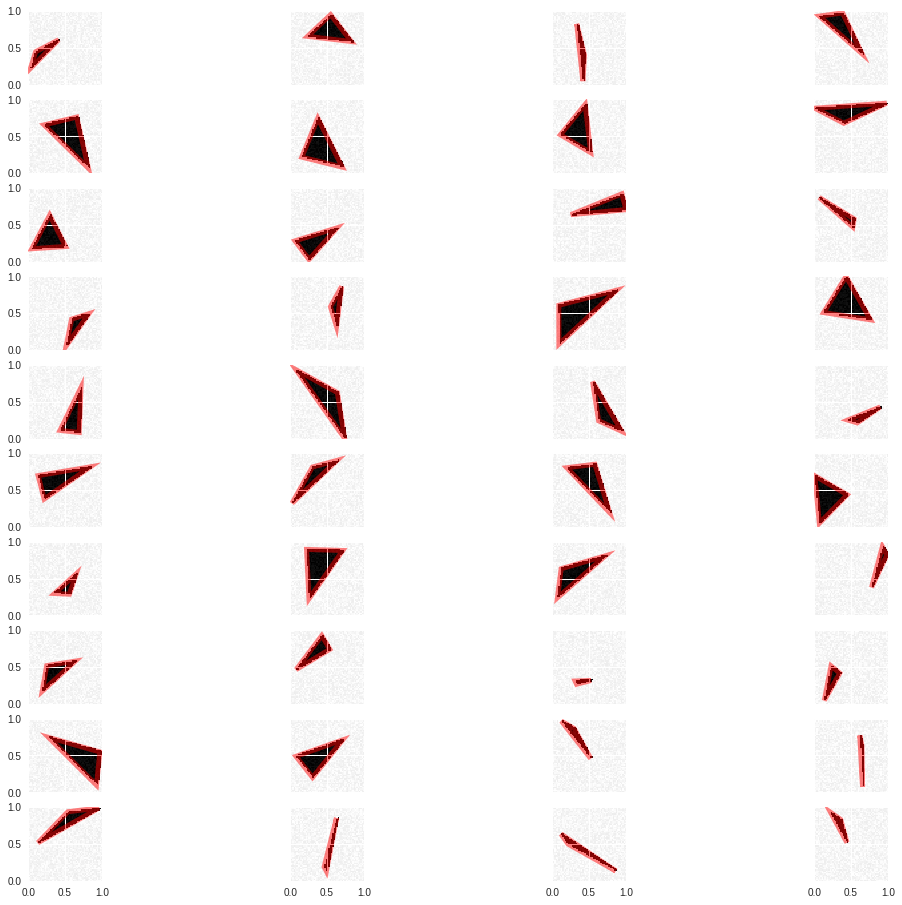

In [0]:
# visualize train set
visualize_prediction(X_train3[0:41], Y_train3[0:41])

In [0]:
# normalizing Y_train 
Y_train_norm = normalize_vertices(Y_train3)

# reshape training set
X_train3 = X_train3.reshape(X_train3.shape[0], IMAGE_SIZE, IMAGE_SIZE,1)

# Fit model
model4 = reg_conv_network(64, 3, 128)
hist = model4.fit(X_train3, Y_train_norm, epochs=100, batch_size=32, validation_split = 0.05)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 70, 70, 64)        640       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 33, 33, 32)        18464     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 14, 14, 32)        9248      
__________

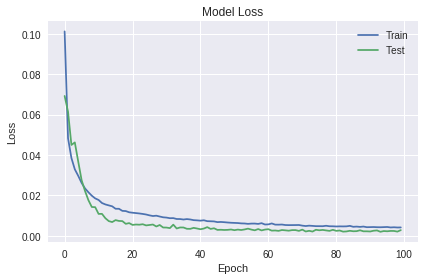

In [0]:
plot(hist)

The optimization part of the model works well, with both training and validation set loss converging to 0. We do not have an overfitting problem since the validation set loss did not increased after a certain number of epochs. 

In [0]:
# generating test set
[X_test3, Y_test3] = generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


300/300 [==============================] - 0s 340us/step
Loss on test set is 0.004351197251429161


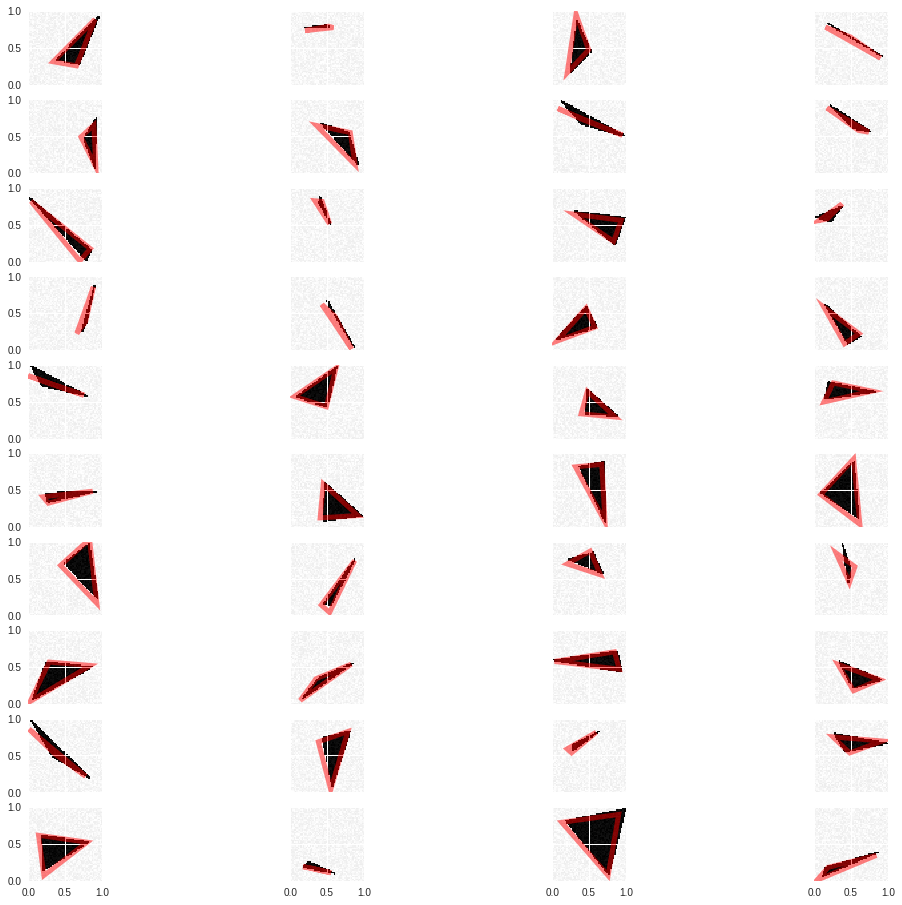

In [0]:
# normalizing Y_test
Y_test3_norm = normalize_vertices(Y_test3)

# reshape test set
X_test3 = X_test3.reshape(X_test3.shape[0], IMAGE_SIZE, IMAGE_SIZE,1)

# Evaluate model
test_loss = model4.evaluate(X_test3, Y_test3_norm)
print('Loss on test set is {}'.format(test_loss))

# Plot prediction
Y_pred = model4.predict(X_test3)
visualize_prediction(X_test3[0:41], Y_pred[0:41])

The loss on the test set is of the same order of magnitude as on the train set (around 0.004), meaning we did not overfit the training set. To assess the performance of the neural network, I also plotted the prediction on 40 triangles of the test set.  We can see that the results are quite good, even on "pathological" triangles which are nearly lines. 

## $\textbf{7 Image Denoising}$

In [0]:
# Rewriting the generate_a_* functions to generate pair of images (one with noise, one w/o noise)

def generate_a_rectangle_bis(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    I1 = generate_a_drawing(figsize, U, V, noise)
    I2 = generate_a_drawing(figsize, U, V, 0.0)
    return [I1,I2]


def generate_a_disk_bis(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    I1 = generate_a_drawing(figsize, U, V, noise)
    I2 = generate_a_drawing(figsize, U, V, 0.0)
    return [I1,I2]
    

def generate_a_triangle_bis(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    I1 = generate_a_drawing(figsize, U, V, noise)
    I2 = generate_a_drawing(figsize, U, V, 0.0)
    return [I1,I2]


def generate_dataset_denoising(nb_samples, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        noise = 40*np.random.random()
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            [X[i],Y[i]] = generate_a_rectangle_bis(noise, free_location)
        elif category == 1: 
            [X[i],Y[i]] = generate_a_disk_bis(noise, free_location)
        else:
            [X[i],Y[i]] = generate_a_triangle_bis(noise, free_location)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]


def generate_test_set_denoising(free_location=False):
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_denoising(300, free_location)
#    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]


In [0]:
from keras.layers import UpSampling2D
from keras.models import Model
from keras import regularizers as r

# Hourglass network

def DAE_CNN(features_shape, act='relu'):

    # Input
    x = Input(name='inputs', shape=features_shape, dtype='float32')
    o = x
    
    # Encoder
    o = Conv2D(32, (3, 3), activation=act, padding='same', strides=(1,1), name='en_conv1', activity_regularizer=r.l1(10e-7))(o) 
    o = MaxPooling2D((2, 2), strides=(2,2), padding='same', name='en_pool1')(o)
    o = Conv2D(32, (3, 3), activation=act, padding='same', strides=(1,1), name='en_conv2', activity_regularizer=r.l1(10e-7))(o)
    enc = MaxPooling2D((2, 2), strides=(2,2), padding='same', name='en_pool2')(o)
    
    # Decoder
    o = Conv2D(32, (3, 3), activation=act, padding='same', strides=(1,1), name='de_conv1', activity_regularizer=r.l1(10e-7))(enc) #
    o = UpSampling2D((2, 2), name='upsampling1')(o)
    o = Conv2D(32, (3, 3), activation=act, padding='same', strides=(1,1), name='de_conv2', activity_regularizer=r.l1(10e-7))(o) #
    o = UpSampling2D((2, 2), name='upsampling2')(o)
    dec = Conv2D(1, (3, 3), activation='sigmoid', padding='same', strides=(1,1), name='de_conv3')(o)
    
    # Print network summary
    Model(inputs=x, outputs=dec).summary()
    
    return Model(inputs=x, outputs=dec)
  
input_shape = (IMAGE_SIZE,IMAGE_SIZE,1)


autoenc = DAE_CNN(input_shape, act='relu')
autoenc.compile(optimizer='adadelta', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 72, 72, 1)         0         
_________________________________________________________________
en_conv1 (Conv2D)            (None, 72, 72, 32)        320       
_________________________________________________________________
en_pool1 (MaxPooling2D)      (None, 36, 36, 32)        0         
_________________________________________________________________
en_conv2 (Conv2D)            (None, 36, 36, 32)        9248      
_________________________________________________________________
en_pool2 (MaxPooling2D)      (None, 18, 18, 32)        0         
_________________________________________________________________
de_conv1 (Conv2D)            (None, 18, 18, 32)        9248      
_________________________________________________________________
upsampling1 (UpSampling2D)   (None, 36, 36, 32)        0         
__________

The idea is to use an autoencoder, ie an encoder network, followed by a decoder network. In the encoding part, I use a combination of convolutionnal/maxpool layers in order to reduce the dimension of the image and extract useful features. On the other side, the decoding part uses a combination of convolutionnal/upsampling layers in order to build again an image based on the useful features extracted by the encoding part. 


---


I added a regularization step in the convolutionnal layers in order to control for overfitting. Without the regularization, the neural network always predicted an "all white" or "all black" image.


---

I use a "binary_crossentropy" loss, which at first sight can seem weird since we are not facing a problem of classification with two classes. However, we can see the denoising problem as a kind of classification problem between two classes, recalling that hourglass networks are also used for image segmentation : one class is the black shape (triangle, rectangle, circle), the other class is the background. As a result, the task of our denoising network is to segment the image between the shape and the background, coloring the background in white and the shape in black, and by doing so denoising the image.

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


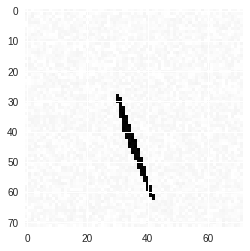

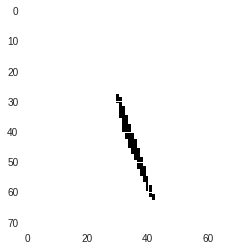

In [0]:
# generate training set
[X_train5, Y_train5] = generate_dataset_denoising(1000, True)

# Reshape training set
X_train5 = X_train5.reshape(X_train5.shape[0], IMAGE_SIZE, IMAGE_SIZE,1)
Y_train5 = Y_train5.reshape(Y_train5.shape[0], IMAGE_SIZE, IMAGE_SIZE,1)

# Visualize noisy and denoised images
plt.figure()
plt.imshow(X_train5[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.figure()
plt.imshow(Y_train5[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


Train on 900 samples, validate on 100 samples
Epoch 1/50
900/900 [==============================] - 2s 2ms/step - loss: -2987.1371 - val_loss: -3730.6309
Epoch 2/50
900/900 [==============================] - 1s 982us/step - loss: -3660.9882 - val_loss: -3731.2072
Epoch 3/50
900/900 [==============================] - 1s 972us/step - loss: -3669.8385 - val_loss: -3732.1060
Epoch 4/50
900/900 [==============================] - 1s 977us/step - loss: -3670.6794 - val_loss: -3732.8481
Epoch 5/50
900/900 [==============================] - 1s 966us/step - loss: -3671.4945 - val_loss: -3733.7434
Epoch 6/50
900/900 [==============================] - 1s 965us/step - loss: -3672.6107 - val_loss: -3735.0802
Epoch 7/50
900/900 [==============================] - 1s 963us/step - loss: -3674.4198 - val_loss: -3735.7480
Epoch 8/50
900/900 [==============================] - 1s 963us/step - loss: -3674.4692 - val_loss: -3737.2966
Epoch 9/50
900/900 [==============================] - 1s 965us/step - loss: 

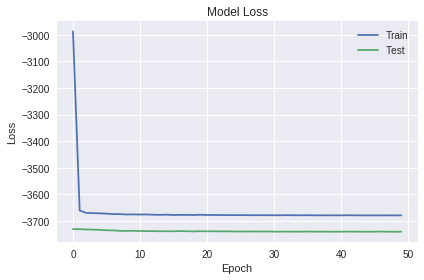

In [0]:
# fit on training set
batch_size = 32
epochs = 50

hist_hg = autoenc.fit(X_train5, Y_train5, epochs=epochs, batch_size=batch_size,
            shuffle=True, validation_split = 0.1)

plot(hist_hg)

Training is effective since both training and validation set losses decreases. What is quite surprising is that both losses converges to a constant value only in a few epochs and then do not improve. Since just looking at the loss is not informative for assessing the denoising performance of our network, we will look at denoising results on a test set.

In [0]:
# Generate test set
[X_test5,Y_test5] = generate_test_set_denoising(True)

# Reshape test set
X_test5 = X_test5.reshape(X_test5.shape[0], IMAGE_SIZE, IMAGE_SIZE,1)
Y_test5 = Y_test5.reshape(Y_test5.shape[0], IMAGE_SIZE, IMAGE_SIZE,1)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [0]:
# Evaluate model
test_loss = autoenc.evaluate(X_test5, Y_test5)
print('Loss on test set is {}'.format(test_loss))

300/300 [==============================] - 0s 485us/step
Loss on test set is -3651.03642578125


Results on the test set are in line with the ones obtained on the training/validation sets, with a loss of -3700. It underlines the fact our network generalizes well, without overfitting the training set. We can check visually the results of the algorithm. 

In [0]:
p = autoenc.predict(X_test5, batch_size=128, verbose=0, steps=None)

In [0]:
def plot_denoising(X, Y):
  # plot 20 couple of noised/denoised figures
  fig, ax = plt.subplots(10, 4, figsize=(18,16), sharex='col', sharey='row')
  l=0
  for i in range(10):
    for j in range(2):
      ax[i,2*j].imshow(X[l].reshape(IMAGE_SIZE,IMAGE_SIZE), extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
      ax[i,2*j].set_xlim([0,1])
      ax[i,2*j].set_ylim([0,1])
      ax[i,2*j].set(adjustable='box-forced', aspect='equal')
      
      ax[i,2*j+1].imshow(Y[l].reshape(IMAGE_SIZE,IMAGE_SIZE), extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
      ax[i,2*j+1].set_xlim([0,1])
      ax[i,2*j+1].set_ylim([0,1])
      ax[i,2*j+1].set(adjustable='box-forced', aspect='equal')
      l +=1     
  plt.show()




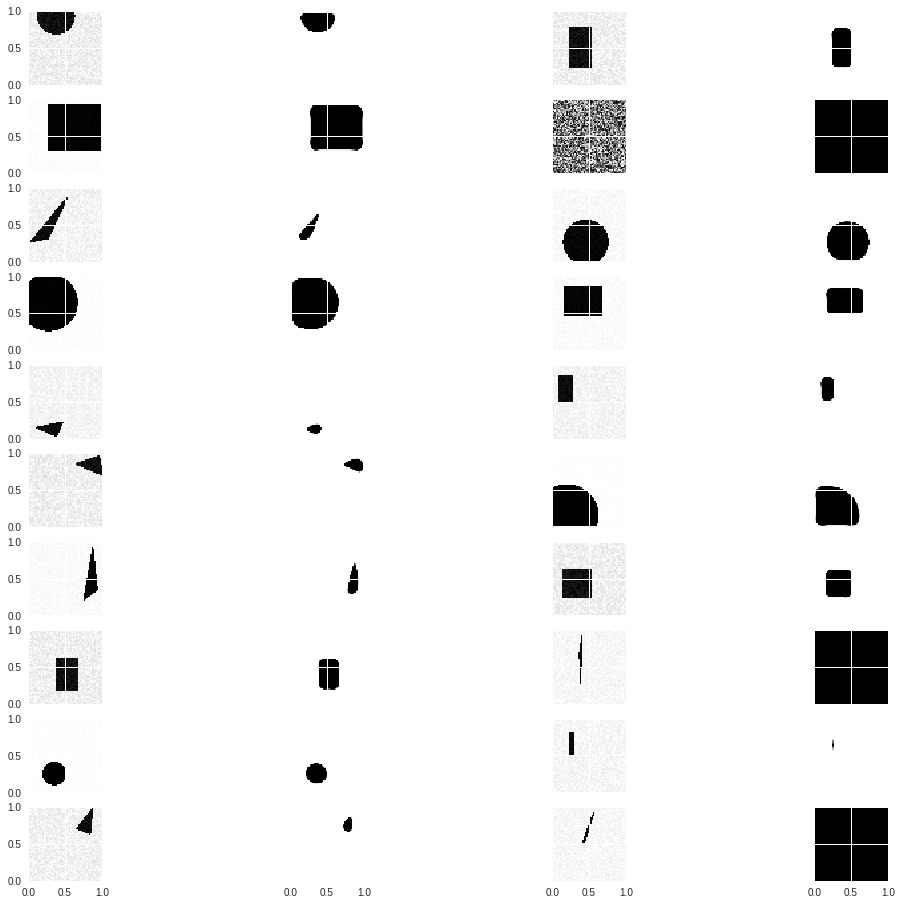

In [0]:
plot_denoising(X_test5[0:21], p[0:21])

Results are honorable, with better results on "big" and centered shapes. The worst results are obtained for very thin shapes that are not centered. It is quite logical since the decision frontier for the network to decide it the pixels belongs to the shape or the background is so small that it can not decides and classifies all the pixels to the background or the shape. That is why one obtains "all black" denoised image.

In [0]:
# save session
dill.dump_session('notebook_env.db')